<a class="anchor" id="toc-go-back"></a>
# Assignment 2: Real-time control of a battery

### Table of Contents
* [0. Loading the data](#data-loading)
* [1. Problem Formulation as a Markov Decision Process (MDP)](#MDP-formulation)
* [2. Discretization of State Space and Transition Probability Estimation](#discretization)

In [1]:
from pathlib import Path
from collections import defaultdict

from typing import Optional

import numpy as np
import pandas as pd
from tqdm import tqdm, trange
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set the path to the data directory and the data save directory
PROCESSED_DIR   = Path('../../../data/assignment1/processed')

<a class="anchor" id="data-loading"></a>
## 0. Loading the data
[_Go to Table of Contents_](#toc-go-back)

We address solving the problem of real-time control of a battery. This is done by using the price signal that was given in assignment 1. For this reason, we will not describe the preprocessing steps here and assume familiarity with this.

For clarity we restrict the battery to being located in the DK1 bidding zone for which reason we only regard the SpotPrice (given in DKK) for this area. 

In [2]:
# Load DK1 and DK2 datasets
DK1_dataset = pd.read_csv(PROCESSED_DIR / 'DK1.csv', index_col=0, parse_dates=['StartTimeUTC', 'EndTimeUTC']).reset_index(drop=True)

# Print the size of the datasets
print(f"DK1 dataset size: {DK1_dataset.shape}")


DK1 dataset size: (17517, 12)


As can be seen on the figure below, the price signal is rather unstationary. In the begining of the considered period, there seem to be a periodic daily pattern (when zooming in) and a slightly increasing price as time evolves. Then in the fall of 2021 the price signal starts increasing in amplitude resulting in a larger variation in the price signal.

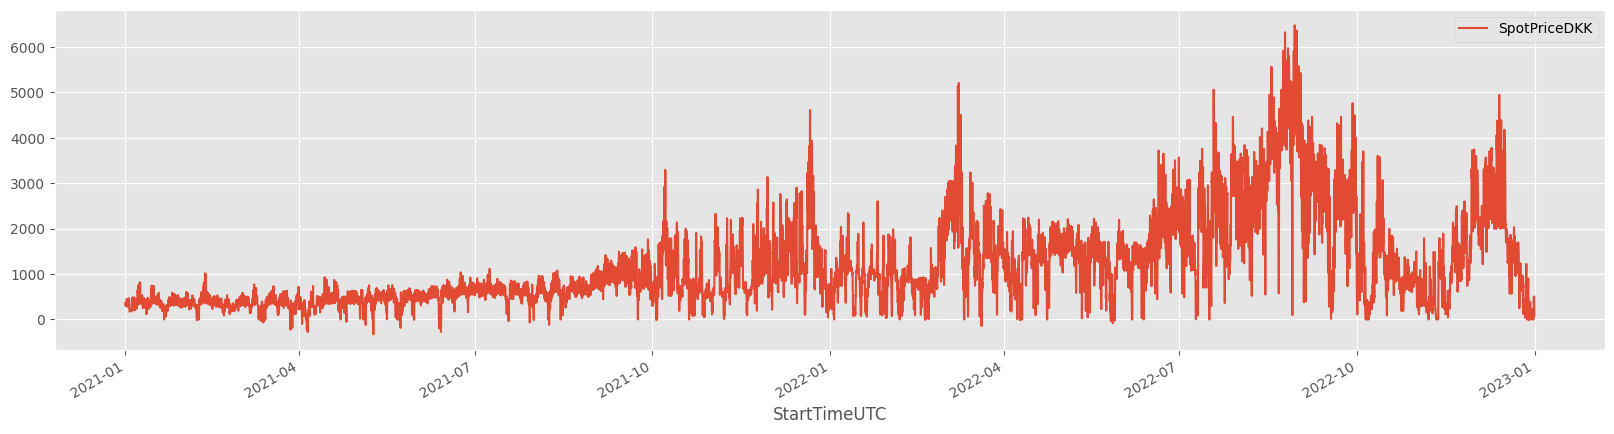

In [3]:
DK1_dataset.plot(x='StartTimeUTC', y='SpotPriceDKK', figsize=(20, 5))
plt.show()

<a class="anchor" id="MDP-formulation"></a>
## 1. Problem Formulation as a Markov Decision Process (MDP)
[_Go to Table of Contents_](#toc-go-back)

A complete and thorough description has been given in the hand-in text. Here we will exploit the formulation directly.

<a class="anchor" id="discretization"></a>
## 2. Discretization of State Space and Transition Probability Estimation
[_Go to Table of Contents_](#toc-go-back)


### 2.1 Discretizing state of charge (SOC) and computing SOC transition probabilities

The underlying discretization approach is also described in the hand-in text. Here we will exploit the formulation directly.

In [4]:
soc_transition_probs    = {}

soc_transition_probs['charge'] = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
])

soc_transition_probs['discharge'] = np.array([
    [1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
])

soc_transition_probs['wait'] = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
])

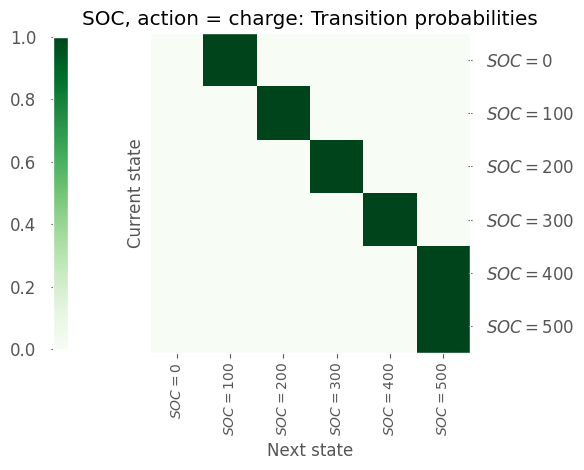

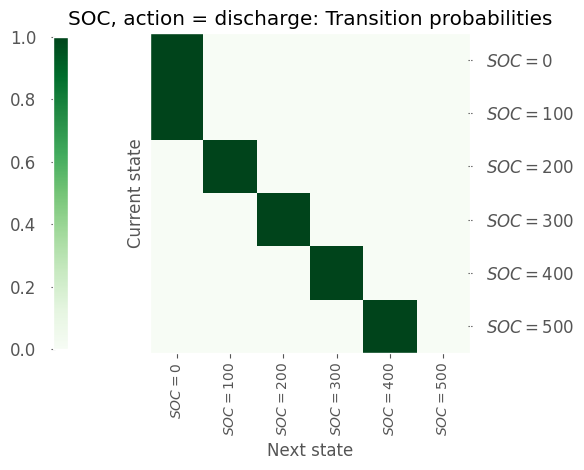

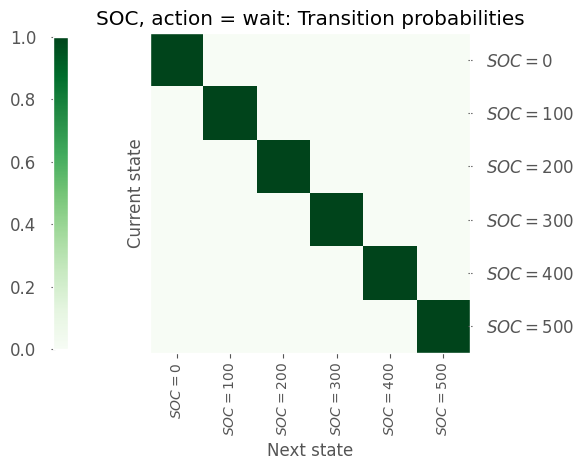

In [5]:
for action, trans_probs_ in soc_transition_probs.items():
    # make axs[0] very small and axs[1] big
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.1, 1]})
    # Visualize transition scores
    img = axs[1].imshow(trans_probs_, cmap='Greens')
    axs[1].set_xlabel('Next state')
    axs[1].set_ylabel('Current state')
    axs[1].set_xticks([0, 1, 2, 3, 4, 5], [f"$SOC={i*100}$" for i in range(6)], rotation=90)
    axs[1].set_yticks([0, 1, 2, 3, 4, 5], [f"$SOC={i*100}$" for i in range(6)])

    axs[1].tick_params(axis='y', which='both', right=True, left=False, labelright=True, labelleft=False, pad=10, labelsize=12, direction='inout')

    axs[1].set_title(f'SOC, action = {action}: Transition probabilities', loc='center')

    axs[0].axis('off')
    cbar = plt.colorbar(img, ax=axs[0], orientation='vertical', fraction=0.35, pad=0.8)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.tick_params(pad=10, labelsize=12, direction='inout')

    plt.grid() # grid on offset
    plt.tight_layout()

### 2.2 Discretizing the price signal

As seen previously, the high- and low electricity prices are non-stationary concepts that evolve over time depending on external factors - e.g. energy mix at the current time and thus also the capacity of renewables and external events introduced by e.g. war - the mathematical definition of high- and low prices requires a bit more concern than what was needed for the SOC. In general, we observe a daily periodic pattern in the spotprice that is higher at peak hours and low at night. We are interested in mapping this daily pattern while accounting for general increasing trends. As such we define the high/low price indicator signal by differencing with the average price over a 48-hour window placed with the current hour at the center. The choice of using the 48-hour window is that a high/low price should both be defined from past and future prices. The indicator signal is then defined as:
$$
    \begin{equation}
        I^{high/low}_t = \begin{cases} 1 & \text{if} \quad \left(\lambda_t - \frac{1}{2 \cdot 24} \sum_{i=1}^{24} \lambda_{t-i} + \lambda_{t+i} \right) \geq 0 \\ 0 & \text{otherwise} \end{cases}
    \end{equation}
$$
where $\lambda_t$ defines the spot price at timestep $t$ and $I^{high/low}_t = 1$ indicator that the price at $t$ is high.

We highlight that the temporal resolution of the price-indicator depends on the averaging length - as such, decreasing the rolling-window length would increase the frequency of the indicator signal.

In [6]:
for t in tqdm(range(24, DK1_dataset.shape[0] - 24), desc='Computing avgWindow_SpotPriceDKK'):
    # Compute past_ and future_ values
    past_   = DK1_dataset.loc[t-25:t-1, 'SpotPriceDKK'].mean() 
    future_ = DK1_dataset.loc[t+1:t+24, 'SpotPriceDKK'].mean()

    # Compute avgWindow_SpotPriceDKK
    DK1_dataset.loc[t, 'avgWindow_SpotPriceDKK'] = (past_ + future_) / 2

Computing avgWindow_SpotPriceDKK:   0%|          | 0/17469 [00:00<?, ?it/s]

Computing avgWindow_SpotPriceDKK: 100%|██████████| 17469/17469 [00:03<00:00, 4627.27it/s]


In [7]:
DK1_dataset['differenced_price']    = DK1_dataset['SpotPriceDKK'] - DK1_dataset['avgWindow_SpotPriceDKK']
DK1_dataset['low_high_indicator']   = DK1_dataset['differenced_price'] >= 0

DK1_dataset = DK1_dataset.dropna().reset_index(drop=True)

In the below figure, the raw price signal, the "differenced" signal and the high/low indicator signal is shown. What is clearly seen is the heteroscedastic noise present in the price signal - this is very clear from the differenced signal. Furthermore, it can be seen that the high-low indicator is quite fluctuative, suggesting that we pick up various price levels even though time evolves and the absolute price level increases.

In [8]:
fig = make_subplots(rows=3, cols=1, row_heights=[3,1,2], shared_xaxes=True)
# Spot price
fig.add_trace(go.Scatter(x=np.array(DK1_dataset['StartTimeUTC']), y=DK1_dataset['SpotPriceDKK'], name='SpotPriceDKK',
                            marker_color='gray', legendgroup='group1', showlegend=True), row=1, col=1)
# Differenced time series
fig.add_trace(go.Scatter(x=np.array(DK1_dataset['StartTimeUTC']), y=DK1_dataset['differenced_price'], name='Differencing',
                            marker_color='green', legendgroup='group1', showlegend=True), row=2, col=1)
# High/low price indicator
fig.add_trace(go.Scatter(x=np.array(DK1_dataset['StartTimeUTC']), y=DK1_dataset['low_high_indicator'], name='High/low price indicator',
                            marker_color='red', legendgroup='group1', showlegend=True), row=3, col=1)

# update layout
fig.update_layout(height=600, width=1200, title_text="SpotPriceDKK and indicator signal of high/low price", title_font_size=24, legend=dict(font=dict(size=16)))
fig.show()

With a daily pattern as obvious as it is, we find it interesting to see the distribution of the high/low price indicator signal across the entire dataset. This gives an indication of whether the high/low labelling approach that we considered is reasonable. Below it is seen that the labeling approach suggested clearly captures low prices at night and high prices during peak load hours.

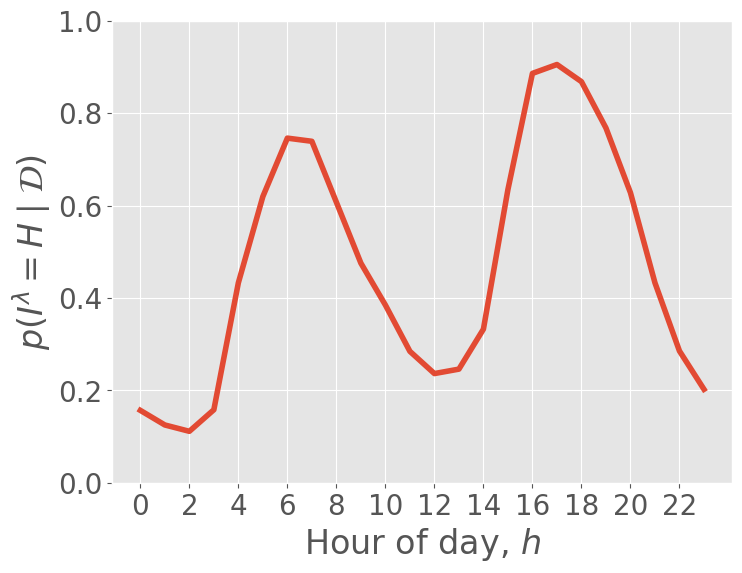

In [9]:
# Add hour
DK1_dataset['Hour'] = DK1_dataset['StartTimeUTC'].dt.hour
# Compute probability of high price per hour (daily pattern)
indicator_prob      = DK1_dataset.groupby('Hour').agg({'low_high_indicator': 'mean'}).reset_index()

fig = plt.figure(figsize=(8, 6))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.plot(indicator_prob['Hour'], indicator_prob['low_high_indicator'], linewidth=4)
plt.ylabel('$p(I^{\lambda}=H \mid \mathcal{D})$', fontsize=24)
plt.xlabel('Hour of day, $h$', fontsize=24)
plt.xticks(np.arange(24)[::2], np.arange(24)[::2])
plt.ylim([0, 1])
# plt.title('Probability of high price per hour (daily pattern)')
# make text larger
plt.show()

We can in addition compute the average number of high/low price hours per day.

In [10]:
DK1_dataset['Date'] = DK1_dataset['StartTimeUTC'].dt.date

date_group = DK1_dataset.groupby('Date').agg({'differenced_price': lambda x: (x >= 0).sum()})
print(f"Average number of high-price hours per day: \n {date_group.mean().item():.3f} \pm {(date_group.std() / np.sqrt(date_group.__len__())).item():.3f}")

date_group = DK1_dataset.groupby('Date').agg({'differenced_price': lambda x: (x < 0).sum()})
print(f"\nAverage number of low-price hours per day: \n {date_group.mean().item():.3f} \pm {(date_group.std() / np.sqrt(date_group.__len__())).item():.3f}")

Average number of high-price hours per day: 
 11.262 \pm 0.155

Average number of low-price hours per day: 
 12.734 \pm 0.155


#### 2.2.1. Estimating the price-transition probabilities from data

In [11]:
price_changes = pd.DataFrame(DK1_dataset['low_high_indicator'].map({False: 'low', True: 'high'})).rename(columns={'low_high_indicator': 'current_price_state'})
price_changes['previous_price_state'] = price_changes.shift(1)
price_changes.head()

,current_price_state,previous_price_state
0,low,None
1,low,low
2,low,low
3,low,low
4,low,low


Transition matrix: 
 [[0.85132333 0.14867667]
 [0.13151365 0.86848635]]


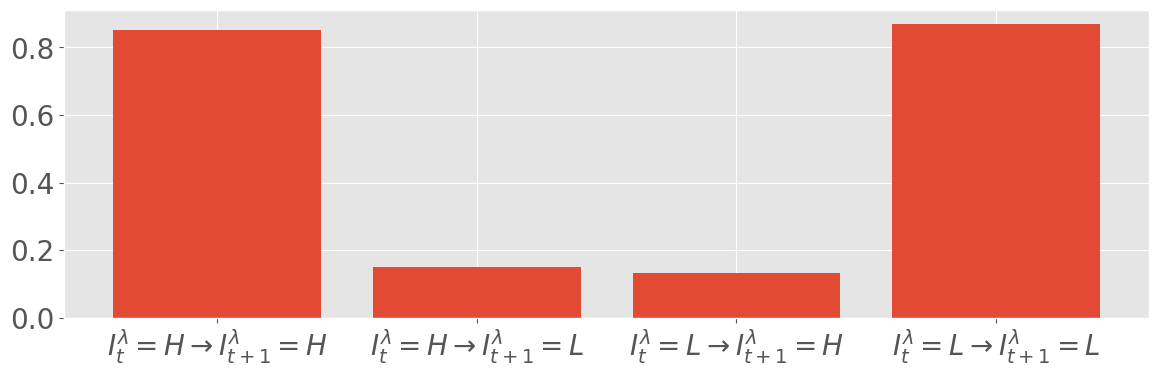

In [12]:
LtoL = price_changes.query('previous_price_state == "low" and current_price_state == "low"').shape[0]   / price_changes.query('previous_price_state == "low"').shape[0]
LtoH = price_changes.query('previous_price_state == "low" and current_price_state == "high"').shape[0]  / price_changes.query('previous_price_state == "low"').shape[0]
HtoL = price_changes.query('previous_price_state == "high" and current_price_state == "low"').shape[0]  / price_changes.query('previous_price_state == "high"').shape[0]
HtoH = price_changes.query('previous_price_state == "high" and current_price_state == "high"').shape[0] / price_changes.query('previous_price_state == "high"').shape[0]

price_probs = np.array([[HtoH, HtoL], [LtoH, LtoL], ])
print(f"Transition matrix: \n {price_probs}")

# Visualize the distribution of the price state changes
plt.figure(figsize=(14, 4))
plt.bar([
    '$I^\lambda_t = H \\rightarrow I^\lambda_{t+1} = H$', 
    '$I^\lambda_t = H \\rightarrow I^\lambda_{t+1} = L$', 
    '$I^\lambda_t = L \\rightarrow I^\lambda_{t+1} = H$', 
    '$I^\lambda_t = L \\rightarrow I^\lambda_{t+1} = L$', 
    ],
    price_probs.flatten()
)
plt.show()

### 2.3. Computing transition probabilities

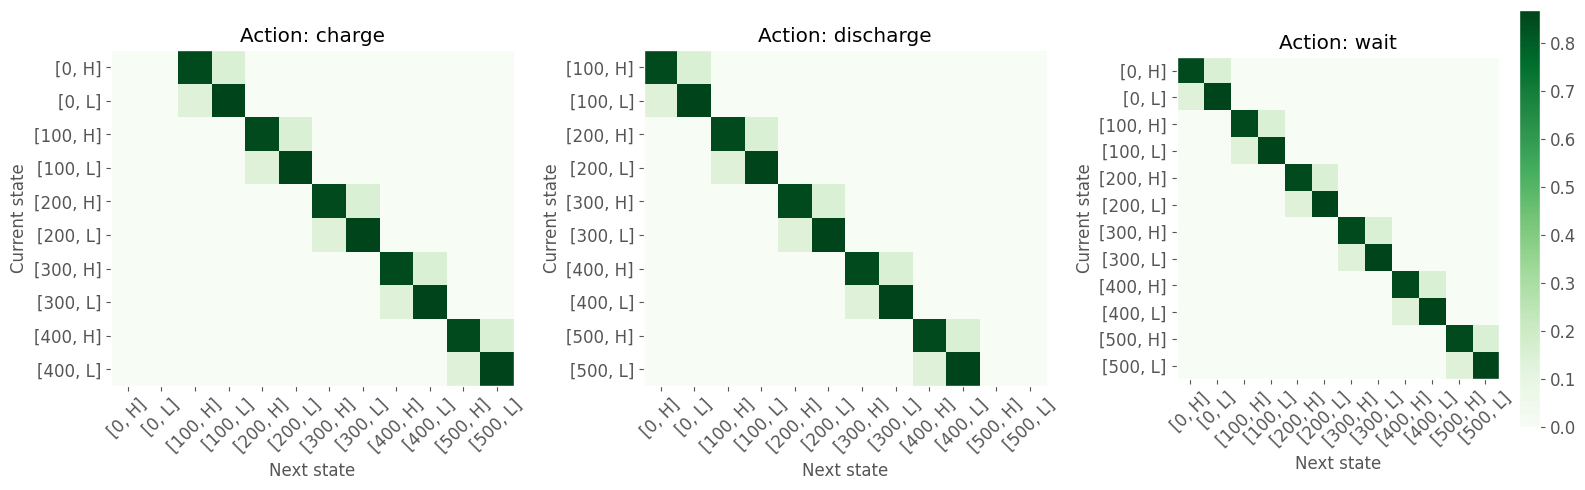

In [13]:
transition_probs = {}
for action, soc_trans_probs_ in soc_transition_probs.items():
    N = soc_trans_probs_.shape[0]
    M = price_probs.shape[0]

    shape_ = N*M
    trans_probs_ = np.zeros((shape_, shape_))
    for row_idx_ in range(N):
        for idx_ in range(shape_):
            trans_probs_[2 * (row_idx_ % 6), idx_]     = soc_trans_probs_[row_idx_ % 6, idx_ // 2] * price_probs[0, idx_ % 2]
            trans_probs_[2 * (row_idx_ % 6) + 1, idx_] = soc_trans_probs_[row_idx_ % 6, idx_ // 2] * price_probs[1, idx_ % 2]

    if action == 'charge':
        trans_probs_ = trans_probs_[:-2]
    elif action == 'discharge':
        trans_probs_ = trans_probs_[2:]

    assert trans_probs_.sum(axis=1).all() == 1, "The transition probabilities do not sum to 1 and are not valid probabilities!"
    index_ = np.arange(N) if action == 'wait' else np.arange(N-1)
    transition_probs[action] = pd.DataFrame(trans_probs_, columns=[str(f"[{c*100}, {p}]") for c in range(6) for p in ['H', 'L']], index=[str(f"[{(c + (action == 'discharge'))*100}, {p}]") for c in index_ for p in ['H', 'L']])


plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(16, 5))
for i, (action, trans_probs_) in enumerate(transition_probs.items()):
    img = axs[i].imshow(trans_probs_, cmap='Greens')
    axs[i].set_xlabel('Next state')
    axs[i].set_ylabel('Current state')
    axs[i].set_title(f'Action: {action}', loc='center')
    axs[i].set_yticks(np.arange(trans_probs_.shape[0]), list(trans_probs_.index))
    axs[i].set_xticks(np.arange(trans_probs_.shape[1]),  list(trans_probs_.columns), rotation=45)

    axs[i].grid(None)

plt.colorbar(img)
# fig.suptitle('Transition probabilities', fontsize=24)
plt.tight_layout()
plt.show()

Lastly, we compute the prices for each price level by averaging from the full data series.

In [14]:
DK1_dataset['upcoming_price_level'] = DK1_dataset['low_high_indicator'].map({False: 'L', True: 'H'})
prices                              = DK1_dataset[['StartTimeUTC', 'upcoming_price_level', 'SpotPriceDKK']].dropna()

reward_prices                       = prices.groupby('upcoming_price_level').SpotPriceDKK.mean()
reward_prices

upcoming_price_level
H    1436.347122
L     887.458551
Name: SpotPriceDKK, dtype: float64

### 2.4. Running Value Iteration

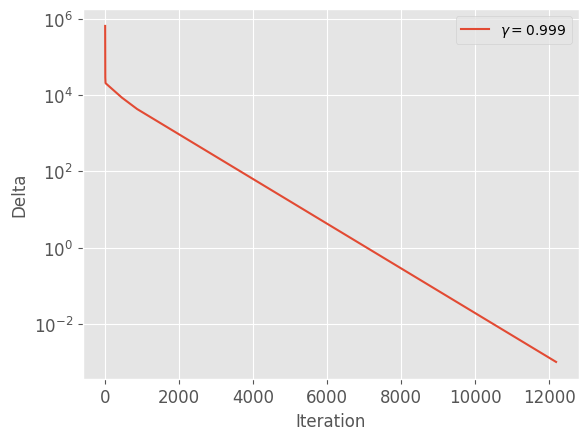

c:\Users\alber\Miniconda3\envs\46765\Lib\site-packages\pandas\core\internals\blocks.py:1616: RuntimeWarning:

overflow encountered in multiply



({'[0, L]': 'Charge',
  '[0, H]': 'Idle',
  '[100, L]': 'Charge',
  '[100, H]': 'Discharge',
  '[200, L]': 'Charge',
  '[200, H]': 'Discharge',
  '[300, L]': 'Charge',
  '[300, H]': 'Discharge',
  '[400, L]': 'Charge',
  '[400, H]': 'Discharge',
  '[500, L]': 'Idle',
  '[500, H]': 'Discharge'},
                    Charge     Discharge          Idle
 0  [0, L]    1.199041e+07          -inf  1.196810e+07
 1  [0, H]    1.190519e+07          -inf  1.191093e+07
 2  [100, L]  1.209673e+07  1.205684e+07  1.207916e+07
 3  [100, H]  1.203753e+07  1.205456e+07  1.204883e+07
 4  [200, L]  1.219845e+07  1.216790e+07  1.218548e+07
 5  [200, H]  1.216448e+07  1.219246e+07  1.218117e+07
 6  [300, L]  1.229572e+07  1.227422e+07  1.228720e+07
 7  [300, H]  1.228621e+07  1.232480e+07  1.230812e+07
 8  [400, L]  1.238866e+07  1.237595e+07  1.238446e+07
 9  [400, H]  1.240288e+07  1.245175e+07  1.242985e+07
 10 [500, L]          -inf  1.247321e+07  1.247740e+07
 11 [500, H]          -inf  1.257348e+07  1.

In [91]:
from src.assignment2.models.Battery import Battery
from src.assignment2.models.ValueIteration import ValueIteration

# Define environment
env = Battery(prices=prices, high_low_prices=reward_prices)
# Create value iteration solver object
solver = ValueIteration(env, gamma=0.999)

# Train the solver
solver.train()

# Visualize convergence curve
plt.plot(solver.delta_history, label=f"$\gamma = {solver.gamma}$")
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.yscale('log')
plt.legend()
plt.show()

# Get optimal policy
optimal_policy, action_values = solver.get_policy()
optimal_policy, action_values.round(4)

# print(action_values.round(2).reset_index().to_latex(float_format="%.2f",index=False))

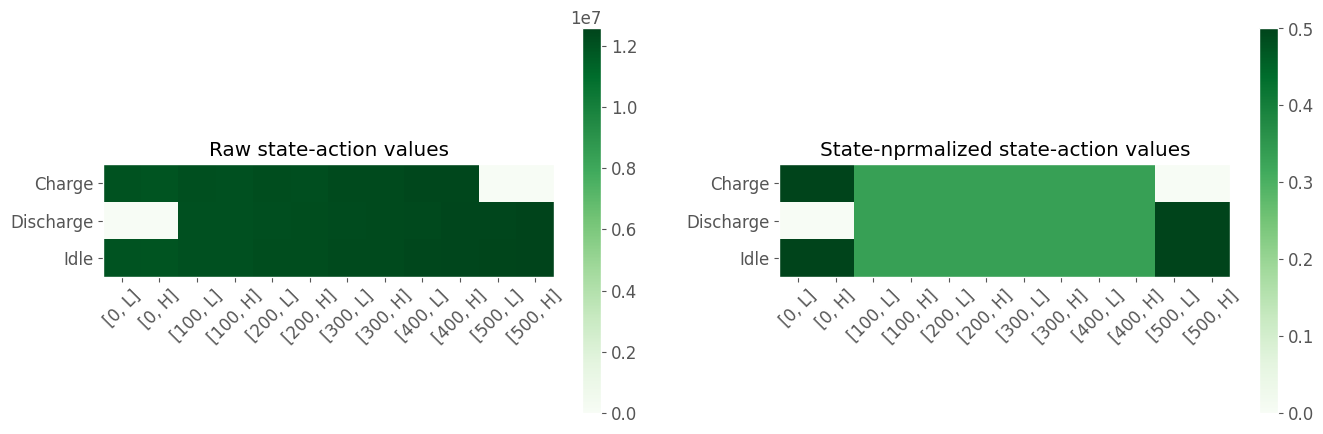

In [93]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 5))
temp = action_values.round(2).replace(-np.inf, 0).to_numpy()

img = axs[0].imshow(temp.T, cmap='Greens')
plt.colorbar(img)
img = axs[1].imshow((temp / temp.sum(axis=1, keepdims=True)).T, cmap='Greens')
plt.colorbar(img)

for i in range(2):
    axs[i].set_yticks(np.arange(len(action_values.columns)), action_values.columns, rotation=0)
    axs[i].set_xticks(np.arange(len(action_values.index)), action_values.reset_index()['level_1'], rotation=45)
    axs[i].grid(None)
    axs[i].set_title('Raw state-action values' if i == 0 else 'State-nprmalized state-action values', loc='center')

plt.show()

In [104]:
horizon = 24*7*4            # one month
policy  = optimal_policy

# Reset environment
state = env.reset(init_soc=200)

# Store transition
env.memory[env.time]['soc']     = state[0]
env.memory[env.time]['price']   = state[1]
env.memory[env.time]['SpotPriceDKK'] = env.prices['SpotPriceDKK'].loc[env.time + 1]

for time_step in tqdm(range(1, horizon), desc='Running simulation...'):
    
    # Determine action
    action = policy[str(f"[{state[0]}, {state[1]}]")]

    # Execute action in environment
    state, reward = env.step(action)
    
    # Store transition
    env.memory[time_step]['soc']            = state[0]
    env.memory[time_step]['price']          = state[1]
    env.memory[time_step]['action']         = action
    env.memory[time_step]['reward']         = reward
    env.memory[time_step]['SpotPriceDKK']   = env.prices['SpotPriceDKK'].iloc[env.time + 1]

res                         = pd.DataFrame.from_dict(env.memory, orient='index')
res['StartTimeUTC']         = prices['StartTimeUTC'][:horizon]
res['price']                = res['price'].map({'L': 0, 'H': 1})
res['action']               = res['action'].map({'Charge': 100, 'Discharge': -100, 'Idle': 0})
res['reward']               = res['reward'] * 1e-3
res['accum_reward']         = res['reward'].cumsum()
res['rolling_accum_reward'] = res['accum_reward'].rolling(24).mean()

### RESULTS ###
subplot_labels = ['[DKK/MWh]', '[High/Low]', '[MWh]', '[1000 DKK]', '[1000 DKK]']

fig = make_subplots(rows=5, cols=1, row_heights=[2,1,3,2,3], vertical_spacing=0.05, shared_xaxes=True)

fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['SpotPriceDKK'], name='Spot price',
                            marker_color='gray', legendgroup='group1', showlegend=True), row=1, col=1)

fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['price'], name='Price indicator',
                            marker_color='red', legendgroup='group1', showlegend=True), row=2, col=1)

fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['soc'], name='State of Charge',
                            marker_color='steelblue', legendgroup='group1', showlegend=True), row=3, col=1)
fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['action'], name='Action',
                            marker_color='blue', legendgroup='group1', showlegend=True), row=3, col=1)

fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['reward'], name='Reward',
                            marker_color='green', legendgroup='group1', showlegend=True), row=4, col=1)

fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['accum_reward'], name='Accum. reward',
                            marker_color='green', legendgroup='group1', showlegend=True), row=5, col=1)
fig.add_trace(go.Scatter(x=np.array(res['StartTimeUTC']), y=res['rolling_accum_reward'], name='Avg. 24 hour accum. reward',
                            marker_color='black', legendgroup='group1', showlegend=True), row=5, col=1)

# update layout
fig.update_layout(height=800, width=1600, title_text=f"1 month evaluation of optimal policy (gamma = {solver.gamma})", title_font_size=24, legend=dict(font=dict(size=16)))
for i in range(5):
    fig['layout'][f'yaxis{i+1}']['title']   = subplot_labels[i]

fig.show()

Running simulation...: 100%|██████████| 671/671 [00:00<00:00, 36913.26it/s]


In [105]:
# TODO: add convergence analysis to overleaf
# TODO: compare the resulting policy qualitatively based on realizations of various gammas
# TODO: compare the accummuative reward for different gammas
# TODO: compare the accummuative reward for different initial conditions
# TODO: experiment with various different values for high/low price states when learning